# Import Libraries and Read Files

In [90]:
import pandas as pd
import numpy as np
import os
import datetime
import random
%config IPCompleter.greedy = True
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from regressors import stats
import statsmodels.api as sm
from rplots import residuals
import sklearn
from sklearn.model_selection import cross_val_predict

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

path = "C:\\Users\\chris\\OneDrive - Irwin's Safety and Industrial Labour Services Ltd\\Irwins\\output\\simulation"
os.listdir(path)

['billable.csv',
 'cec_data.csv',
 'cec_data_tool_time.csv',
 'company_score.csv',
 'islam_data.csv',
 'islam_data2.csv',
 'rfid_simulation.csv',
 'workers.csv',
 'work_coverage.csv']

In [9]:
cec_2018 = pd.read_csv(path+'\\cec_data.csv',
                       parse_dates=['clean_date', 'start_time', 'stop_time', 'work_start'])
cec_2018.rename(columns={"vessel_entry":"work_area"},inplace=True)
events = pd.read_csv(path+'\\rfid_simulation.csv',
                     parse_dates=['TimeIn', 'TimeOut'], index_col='eventid')
events.columns = ['workerid','time_in','time_out','index_id']
workers = pd.read_csv(path+"\\workers.csv")

## Add "area" to better categorize the working environment

In [10]:
vessel_keys = np.sort(cec_2018['vessel_clean'].unique())
vessel_values = ['Other', 'Combustion Turbine', 'Combustion Turbine',
       'Combustion Turbine', 'Combustion Turbine','Combustion Turbine', 'Other',
       'Condenser', 'Condenser', 'Cooling Tower',
       'Cooling Tower', 'Other', 'Other',
       'HP Steam Drum', 'HRSG', 'HRSG',
       'HRSG', 'HP Steam Drum', 'LP Drum',
       'HRSG', 'Other', 'LP Drum',
       'Condenser', 'Steam Turbine', 'Steam Turbine',
       'Other']
vessel_dict = {vessel_keys[i]:vessel_values[i] for i in range(len(vessel_keys))}
cec_2018['area'] = cec_2018['vessel_clean'].map(vessel_dict)
# Create a pivot table to show how tool time varies by "area"
area_tooltime = (cec_2018[pd.notnull(cec_2018['code_phase'])].
                          pivot_table(values='duration',index=['area'],columns='code_phase',
                                      aggfunc='sum'))
area_tooltime['tool_time_pct'] = (area_tooltime['tool_time']/
                                  area_tooltime.iloc[:,0:5].sum(axis=1))
area_tooltime

code_phase,down_time,idle_time,nonwork_time,tool_time,wait_time,tool_time_pct
area,,,,,,
Combustion Turbine,44.650000,89.433333,7.083333,135.083333,10.600000,0.470920
Condenser,3.666667,6.016667,4.800000,24.783333,0.583333,0.621916
Cooling Tower,5.300000,2.083333,1.783333,38.866667,0.800000,0.795904
HP Steam Drum,9.016667,9.150000,2.866667,50.233333,1.216667,0.693033
HRSG,14.600000,22.350000,2.300000,84.133333,3.816667,0.661426
LP Drum,2.283333,8.650000,0.150000,26.250000,1.433333,0.677128
Other,16.483333,7.133333,0.533333,44.800000,1.800000,0.633216
Steam Turbine,2.383333,4.916667,0.783333,16.333333,1.216667,0.637191


## Add a feature that indicates amount of tool time during a given "phase"

In [11]:
tool_time_by_phase = cec_2018[cec_2018['code_phase'] == "tool_time"].groupby(
    ['csas_id', 'start_phase'])['duration'].sum()
tool_time_by_phase.rename('tool_time',inplace=True)
cec_2018=cec_2018.merge(tool_time_by_phase, left_on=[
               'csas_id', 'start_phase'], right_on=tool_time_by_phase.index.names, how='left')

In [12]:
cec_2018[cec_2018['tool_time'] > 0].pivot_table(
    index=['csas_id', 'work_area', 'work_order', 'start_phase'], 
    columns='code_phase', values='duration', aggfunc='sum')

code_phase                                                        down_time  \
csas_id    work_area                      work_order start_phase              
16064865   CT Generator: Door 51          21142419   1.0           0.816667   
47431840   Condenser Waterbox: Door 38    21118243   2.0           0.250000   
                                                     3.0                NaN   
125163869  Hotwell Upper Access: Door 41A 21150431   1.0           1.000000   
                                                     2.0           0.116667   
...                                                                     ...   
9977982285 Cooling Tower Basin: Door 103  21098206   2.0                NaN   
                                                     3.0                NaN   
                                                     4.0                NaN   
9994318580 ST Generator: Door 44          21098749   1.0           0.400000   
                                                     3.0                NaN   

code_phase                                                        idle_time  \
csas_id    work_area                      work_order start_phase              
16064865   CT Generator: Door 51          21142419   1.0           1.283333   
47431840   Condenser Waterbox: Door 38    21118243   2.0           0.116667   
                                                     3.0                NaN   
125163869  Hotwell Upper Access: Door 41A 21150431   1.0           0.116667   
                                                     2.0                NaN   
...                                                                     ...   
9977982285 Cooling Tower Basin: Door 103  21098206   2.0           0.016667   
                                                     3.0           0.000000   
                                                     4.0           0.050000   
9994318580 ST Generator: Door 44          21098749   1.0           0.483333   
                                                     3.0           0.750000   

code_phase                                                        nonwork_time  \
csas_id    work_area                      work_order start_phase                 
16064865   CT Generator: Door 51          21142419   1.0                   NaN   
47431840   Condenser Waterbox: Door 38    21118243   2.0                   NaN   
                                                     3.0                   NaN   
125163869  Hotwell Upper Access: Door 41A 21150431   1.0                   NaN   
                                                     2.0                   NaN   
...                                                                        ...   
9977982285 Cooling Tower Basin: Door 103  21098206   2.0                   NaN   
                                                     3.0                   NaN   
                                                     4.0                  0.15   
9994318580 ST Generator: Door 44          21098749   1.0                   NaN   
                                                     3.0                  0.05   

code_phase                                                        tool_time  \
csas_id    work_area                      work_order start_phase              
16064865   CT Generator: Door 51          21142419   1.0           2.300000   
47431840   Condenser Waterbox: Door 38    21118243   2.0           1.833333   
                                                     3.0           2.450000   
125163869  Hotwell Upper Access: Door 41A 21150431   1.0           2.283333   
                                                     2.0           2.750000   
...                                                                     ...   
9977982285 Cooling Tower Basin: Door 103  21098206   2.0           3.066667   
                                                     3.0           0.816667   
                                                     4.0           2.233333   
99943185

In [13]:
# Investigate how efficient given phases are
phase_efficiency = cec_2018[cec_2018['tool_time'] > 0].pivot_table(
    index=['start_phase'], 
    columns='code_phase', values='duration', aggfunc='sum')
phase_efficiency['tool_time_pct'] = phase_efficiency['tool_time']/phase_efficiency.sum(axis=1)*100
phase_efficiency

code_phase,down_time,idle_time,nonwork_time,tool_time,wait_time,tool_time_pct
start_phase,,,,,,
1.0,85.050000,52.400000,1.633333,138.350000,6.450000,48.734809
2.0,1.950000,19.150000,3.600000,119.333333,5.650000,79.723861
3.0,1.066667,20.466667,2.816667,121.933333,4.666667,80.777299
4.0,0.416667,9.350000,0.433333,39.333333,2.433333,75.689545
5.0,NaN,NaN,0.050000,1.533333,0.000000,96.842105


# Merge Dataframes and Feature Engineering

In [14]:
# add worker details to rfid events
events = events.merge(workers,left_on = 'workerid',right_on='workerid',how='left')
events['worked_hours'] = (events.time_out-events.time_in).astype('timedelta64[s]')/3600
cec_2018_2 = cec_2018.merge(events,right_on='index_id',left_on='index_id',how='left')

In [15]:
def kpi_work_area (df):
    """ this function groups a dataframe by date, shift and work area and calculates tool
    time percentage"""
    df_tool_time = df.pivot_table(values='duration', index=['clean_date','shift','work_area',], 
                                columns='code_phase',aggfunc='sum')
    df_tool_time['tool_time_pct'] = (df_tool_time['tool_time'] /
                                     df_tool_time.iloc[:, 0:5].sum(axis=1))
    return df_tool_time

In [16]:
def feature_engineering_work_area(df):
    """ this function groups a dataframe then creates features for crew size, number of phases, and 
    total observed time  """
    df_features = df.groupby(['clean_date', 'work_area', 'area', 'shift', 'days_from_start'])[
        ['crew_size', 'start_phase', 'duration']].agg({'crew_size': 'max', 'start_phase': 'max',
                                                       'duration': 'sum'}).reset_index()
    df_daily = df.groupby(['clean_date', 'shift'])[['csas_id']].nunique()
    df_daily.columns=['work_area_count']
    df_features = df_features.merge(df_daily, left_on=['clean_date', 'shift'], right_on=[
                                    'clean_date', 'shift'], how='left')
    df_features.set_index(['clean_date','shift','work_area'],inplace=True)
    return df_features

In [17]:
# Create new dataframes and merge for machine learning inputs
kpi = kpi_work_area(cec_2018)
features = feature_engineering_work_area(cec_2018)
cec_2018_ml = pd.concat([features,kpi[['tool_time_pct']]],axis=1)
cec_2018_ml = pd.concat([cec_2018_ml,pd.get_dummies(cec_2018_ml['area'])],axis=1)
cec_2018_ml.head()

area  \
clean_date shift work_area                                       
2018-05-26 Night CT Generator: Door 51      Combustion Turbine   
2018-05-27 Night CT Generator: Door 50      Combustion Turbine   
2018-05-28 Day   CT Exhaust Duct: Door 48A  Combustion Turbine   
                 CT Inlet Scroll: Door 46   Combustion Turbine   
2018-05-29 Day   CT Generator: Door 51      Combustion Turbine   

                                            days_from_start  crew_size  \
clean_date shift work_area                                               
2018-05-26 Night CT Generator: Door 51                    0        2.0   
2018-05-27 Night CT Generator: Door 50                    1        4.0   
2018-05-28 Day   CT Exhaust Duct: Door 48A                2        2.0   
                 CT Inlet Scroll: Door 46                 2        4.0   
2018-05-29 Day   CT Generator: Door 51                    3        4.0   

                                            start_phase  duration  \
clean_date shift work_area                                          
2018-05-26 Night CT Generator: Door 51              2.0  4.083333   
2018-05-27 Night CT Generator: Door 50              3.0  4.433333   
2018-05-28 Day   CT Exhaust Duct: Door 48A          2.0  2.916667   
                 CT Inlet Scroll: Door 46           3.0  6.066667   
2018-05-29 Day   CT Generator: Door 51              4.0  9.583333   

                                            work_area_count  tool_time_pct  \
clean_date shift work_area                                                   
2018-05-26 Night CT Generator: Door 51                    1       0.506122   
2018-05-27 Night CT Generator: Door 50                    1       0.518797   
2018-05-28 Day   CT Exhaust Duct: Door 48A                2       0.125714   
                 CT Inlet Scroll: Door 46                 2       0.296703   
2018-05-29 Day   CT Generator: Door 51                    2       0.457391   

                                            Combustion Turbine  Condenser  \
clean_date shift work_area                                                  
2018-05-26 Night CT Generator: Door 51                       1          0   
2018-05-27 Night CT Generator: Door 50                       1          0   
2018-05-28 Day   CT Exhaust Duct: Door 48A                   1          0   
                 CT Inlet Scroll: Door 46                    1          0   
2018-05-29 Day   CT Generator: Door 51                       1          0   

                                            Cooling Tower  HP Steam Drum  \
clean_date shift work_area                                                 
2018-05-26 Night CT Generator: Door 51                  0              0   
2018-05-27 Night CT Generator: Door 50                  0              0   
2018-05-28 Day   CT Exhaust Duct: Door 48A              0              0   
                 CT Inlet Scroll: Door 46               0              0   
2018-05-29 Day   CT Generator: Door 51                  0              0   

                                            HRSG  LP Drum  Other  \
clean_date shift work_area                                         
2018-05-26 Night CT Generator: Door 51         0        0      0   
2018-05-27 Night CT Generator: Door 50         0        0      0   
2018-05-28 Day   CT Exhaust Duct: Door 48A     0        0      0   
                 CT Inlet Scroll: Door 46      0        0      0   
2018-05-29 Day   CT Generator: Door 51         0        0      0   

                                            Steam Turbine  
clean_date shift work_area                                 
2018-05-26 Night CT Generator: Door 51                  0  
2018-05-27 Night CT Generator: Door 50                  0  
2018-05-28 Day   CT Exhaust Duct: Door 48A              0  
                 CT Inlet Scroll: Door 46               0  
2018-05-29 Day   CT Generator: Door 51                  0

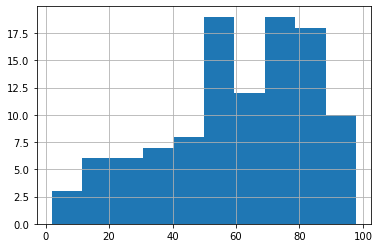

In [18]:
# Assign X and Y variables based on select columns from the dataframe
X = cec_2018_ml.drop(['area','tool_time_pct'],axis=1)
Y = cec_2018_ml['tool_time_pct']*100
Y.hist()

# Supervised Space

## Regression (and Regularization)

In [37]:
# investigate the shape of the dataframe to see if curse of dimensionality
cec_2018_ml.shape

(108, 15)

### Linear Regression

In [48]:
# create regression model
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X,Y)
X2 = sm.add_constant(X)
est = sm.OLS(Y,X2)
est2=est.fit()
print(est2.summary())
print("\nMSE = ",cross_val_score(model_lr,X,Y,scoring='neg_mean_squared_error').mean()*-1)

                            OLS Regression Results                            
Dep. Variable:          tool_time_pct   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     2.928
Date:                Thu, 03 Dec 2020   Prob (F-statistic):            0.00170
Time:                        11:38:55   Log-Likelihood:                -478.83
No. Observations:                 108   AIC:                             983.7
Df Residuals:                      95   BIC:                             1019.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 42.2739      9

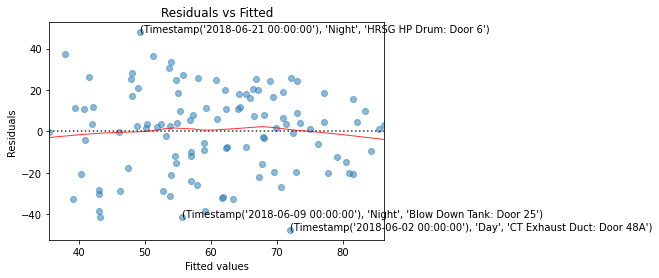

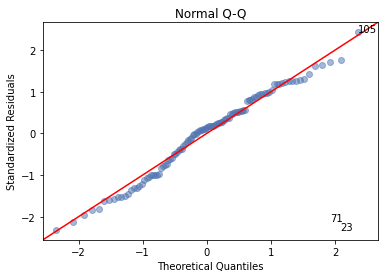

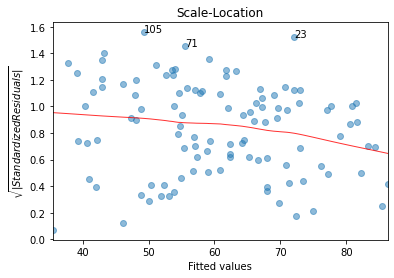

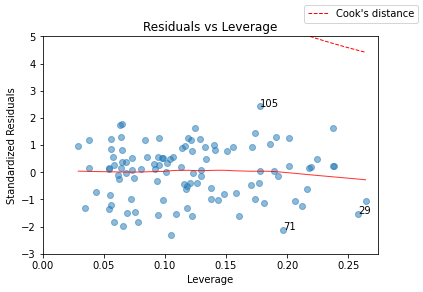

In [39]:
residuals.diagnostic_plots(X,Y)

### Lasso

In [40]:
# See if model is improved by regularization
# Use for loop to find best alpha value
alphas = np.arange(0.01,1,.01)
alpha_list = []
mse_list = []
for i in alphas:
    model_lasso = Lasso(fit_intercept=True,alpha=i)
    model_lasso.fit(X,Y)
    alpha_list.append(i)
    mse_list.append(cross_val_score(model_lasso,X,Y,scoring='neg_mean_squared_error').mean()*-1)
alpha_df = pd.DataFrame(zip(alpha_list,mse_list),columns=['alpha','mse'])
alpha_df.iloc[alpha_df['mse'].idxmin(),:]

alpha      0.830000
mse      510.441642
Name: 82, dtype: float64

In [49]:
# Alternatively, use a grid search to return the same information
model_lasso = Lasso(fit_intercept=True)
grid = GridSearchCV(estimator=model_lasso, param_grid=dict(
    alpha=alphas), cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
print("Alpha= {:.2f}, MSE= {:.2f}".format(grid.best_estimator_.alpha,grid.best_score_))

Alpha= 0.83, MSE= -510.44


In [53]:
model_lasso = Lasso(fit_intercept=True,alpha=.83)
model_lasso.fit(X,Y)
print(cross_val_score(model_lasso,X,Y,scoring='neg_mean_squared_error').mean()*-1)
print(model_lasso.coef_)
print("\n",stats.summary(model_lasso,X,Y))

510.4416421767226
[  0.31188973   2.33411073   4.37158058  -1.76593212   0.78302833
 -14.76537841   0.           0.           0.           0.
   0.          -0.          -0.        ]
Residuals:
     Min       1Q  Median       3Q      Max
-47.0346 -15.7004 -1.7213  13.5983  48.6088


Coefficients:
             Estimate                  Std. Error             t value   p value
_intercept  49.187654  8.010543e+07+0.000000e+00j  0.000000+0.000000j  1.000000
x1           0.311890  2.458000e-02+5.960700e-01j  0.021500-0.522400j  0.602195
x2           2.334111  1.073638e+00-7.881000e-03j  2.173900+0.016000j  0.031912
x3           4.371581  2.375824e+00+2.598000e-03j  1.840000-0.002000j  0.068536
x4          -1.765932  6.838250e-01-2.509000e-02j -2.579000-0.094600j  0.011215
x5           0.783028  9.315490e-01-1.707400e-02j  0.840300+0.015400j  0.402545
x6         -14.765378  8.010542e+07+1.223000e-03j -0.000000+0.000000j  1.000000
x7           0.000000  8.010542e+07+1.100000e-05j  0.000000+0.

### Ridge Regression

In [52]:
model_ridge = Ridge()
grid = GridSearchCV(estimator=model_ridge, param_grid=dict(
    alpha=alphas), cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
print("Alpha= {:.2f}, MSE= {:.2f}".format(grid.best_estimator_.alpha,grid.best_score_))

Alpha= 0.99, MSE= -555.13


In [54]:
model_ridge = Ridge(alpha=grid.best_estimator_.alpha)
model_ridge.fit(X,Y)
print(cross_val_score(model_ridge,X,Y,scoring='neg_mean_squared_error').mean()*-1)
print(model_ridge.coef_)
print("\n",stats.summary(model_ridge,X,Y))

555.1281008345491
[  0.19318509   2.55080988   6.11780167  -2.16754078   0.75229488
 -16.76405425   1.09047805  10.24856692   5.1045522    1.56956186
   7.03215632  -4.36834466  -3.91291645]
Residuals:
     Min      1Q  Median       3Q      Max
-48.0357 -16.516 -2.7149  15.4113  47.7367


Coefficients:
             Estimate                  Std. Error             t value   p value
_intercept  46.939987  7.823308e+07+0.000000e+00j  0.000000+0.000000j  1.000000
x1           0.193185  1.080700e-01+6.937500e-01j  0.042400-0.271900j  0.783734
x2           2.550810  1.036780e+00-1.547100e-02j  2.459800+0.036700j  0.015493
x3           6.117802  2.324111e+00+7.756000e-03j  2.632300-0.008800j  0.009735
x4          -2.167541  6.510670e-01-3.377900e-02j -3.320300-0.172300j  0.001213
x5           0.752295  9.035450e-01-9.443000e-03j  0.832500+0.008700j  0.406948
x6         -16.764054  7.823307e+07+2.184100e-02j -0.000000+0.000000j  1.000000
x7           1.090478  7.823308e+07+1.000000e-06j  0.000

## Tree Based Methods

### Decision Tree

579.0974335636804


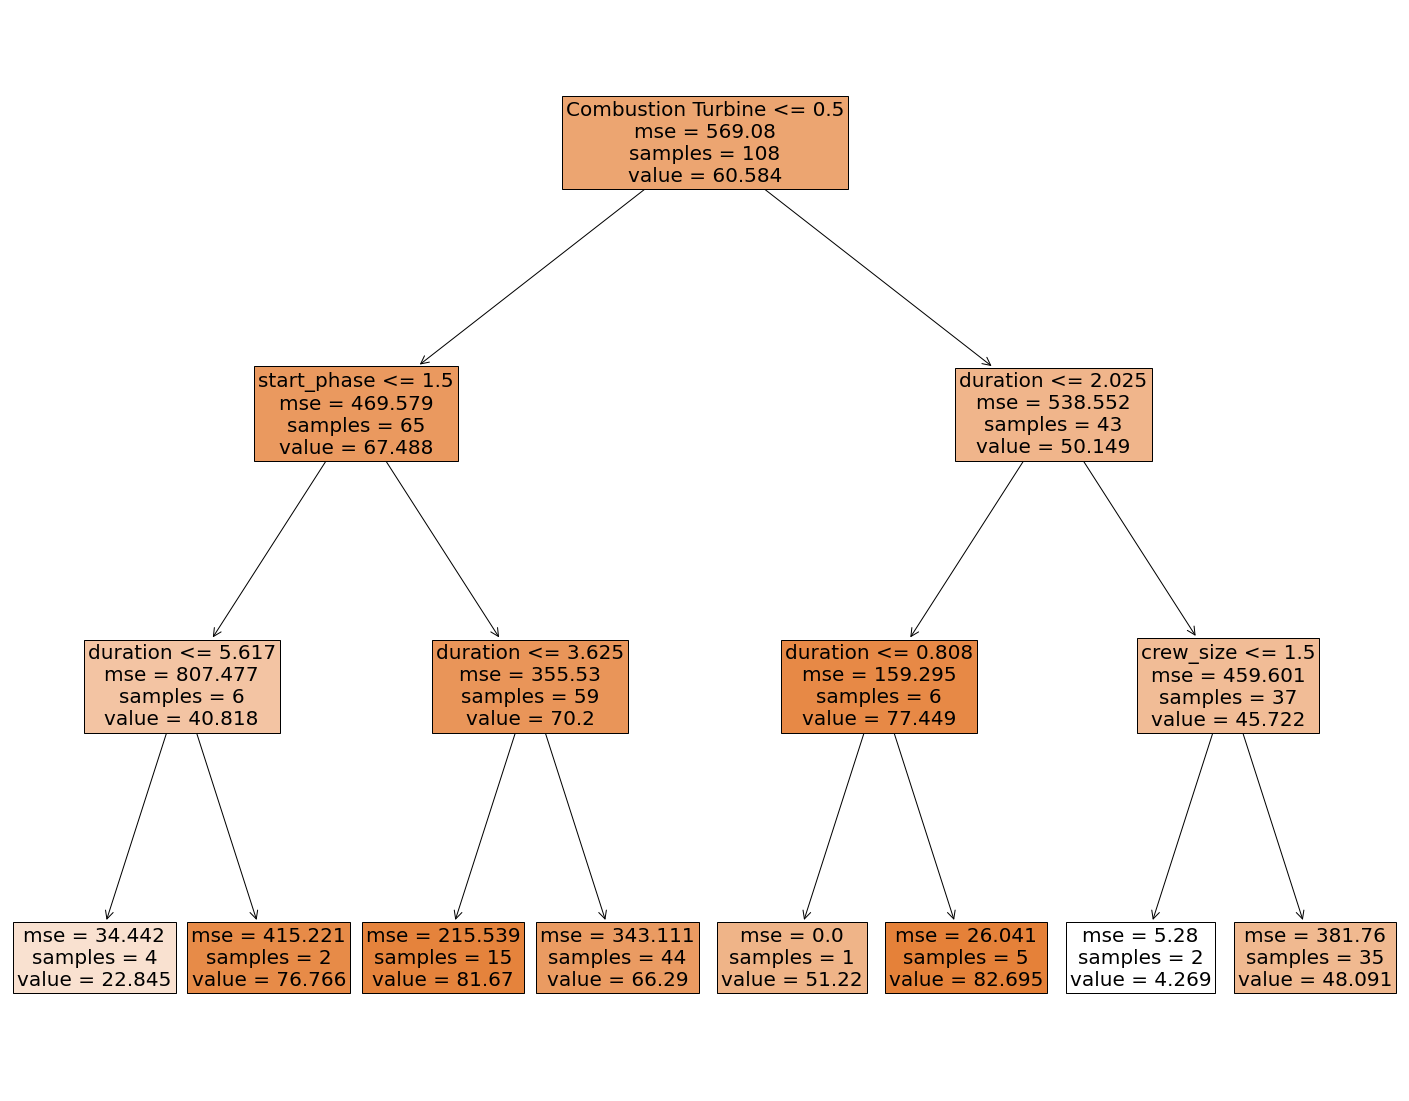

In [105]:
model_tree = DecisionTreeRegressor(max_depth=3,random_state=0)
model_tree.fit(X,Y)
print(cross_val_score(model_tree,X,Y,scoring='neg_mean_squared_error',cv=5).mean()*-1)
fig  = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_tree, feature_names=X.columns,fontsize=20,filled=True)

# Unsupervised space

## Clustering on Workorders

In [11]:
wo_df = cec_2018.groupby('work_order')[['duration', 'clean_date', 'crew_size']].agg(
    {'duration': 'sum', 'clean_date': 'nunique', 'crew_size': 'mean'})

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
wo_df_scale = scaler.fit_transform(wo_df)
wo_df_scale = pd.DataFrame(wo_df_scale, columns = ['total_hours','days','avg_crew'])
wo_df_scale.head()

,total_hours,days,avg_crew
0,0.035683,0.000000,0.833333
1,0.316389,0.500000,0.311111
2,0.057594,0.000000,0.833333
3,0.282083,0.250000,0.458333
4,0.096907,0.166667,0.500000


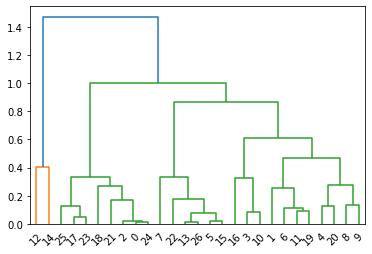

In [13]:
import scipy.cluster.hierarchy as shc
dend = shc.dendrogram(shc.linkage(wo_df_scale, method='complete'))

In [14]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='complete')
model.fit_predict(wo_df_scale)
labels= model.labels_
wo_df['labels'] = labels

In [15]:
wo_df.head()

,duration,clean_date,crew_size,labels
work_order,,,,
21091147,5.916667,1,6.000000,2
21097627,43.283333,7,2.866667,0
21098008,8.833333,1,6.000000,2
21098206,38.716667,4,3.750000,0
21098749,14.066667,3,4.000000,0


In [16]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(wo_df_scale)
D.shape

(27, 27)

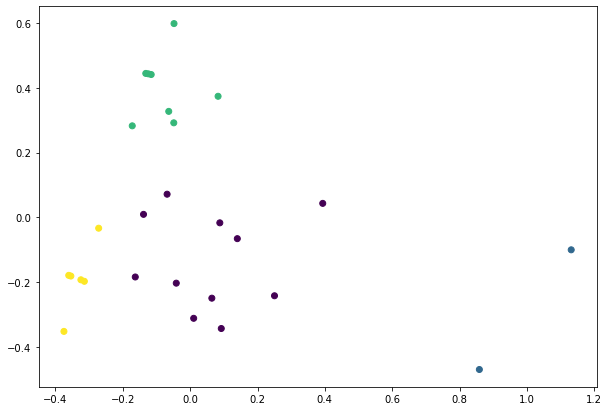

In [17]:
from sklearn.manifold import MDS
model=MDS(n_components=2,dissimilarity='precomputed',random_state=1)
out=model.fit_transform(D)
plt.figure(figsize=(10,7))
plt.scatter(out[:,0],out[:,1],c=labels)

In [18]:
workorder_tooltime = (cec_2018[pd.notnull(cec_2018['code_phase'])].
                          pivot_table(values='duration',index=['work_order'],columns='code_phase',
                                      aggfunc='sum'))
workorder_tooltime['tool_time_pct'] = (workorder_tooltime['tool_time']/
                                  workorder_tooltime.iloc[:,0:5].sum(axis=1))

In [19]:
wo_df['tool_time_pct']=workorder_tooltime['tool_time_pct']

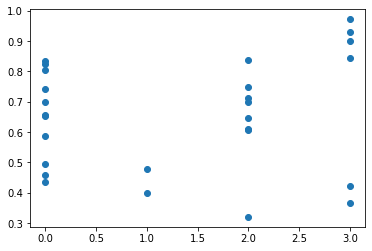

In [20]:
plt.scatter(wo_df['labels'],wo_df['tool_time_pct'])

## Principal Component Analysis

In [47]:
from sklearn.preprocessing import scale
X_df = cec_2018_ml.drop('tool_time_pct',axis=1)
X = X_df.fillna(0)
X = scale(X)
X

array([[-0.6940117 , -1.00647602, -0.65806389, ..., -0.41338369,
        -1.32818742, -0.37796447],
       [-0.74505762, -0.96842742, -0.60619679, ..., -0.96456195,
        -0.57519927, -0.37796447],
       [-0.89819535, -0.54989284,  1.35178642, ..., -0.68897282,
        -0.57519927, -0.37796447],
       ...,
       [-0.10187913, -0.89233022, -0.65806389, ...,  0.13779456,
        -1.07719137,  2.64575131],
       [-0.89819535, -0.8434106 , -0.65806389, ..., -0.41338369,
        -1.07719137, -0.37796447],
       [-0.61744284, -1.01734705, -0.65806389, ..., -0.96456195,
        -1.32818742, -0.37796447]])

In [48]:
from sklearn.decomposition import PCA
pca=PCA(n_components=24)
pca.fit_transform(X)

array([[-3.59348884e+00,  8.08361717e-02, -3.49111247e-01,
         4.60426871e-01,  4.44700211e-01,  2.55362584e-01,
         6.61437848e-02, -3.78762907e-01, -3.72931533e-01,
        -4.60591361e-01, -2.28568775e-02, -8.86841974e-01,
        -5.48485134e-02, -2.59183650e-01,  1.56614688e-01,
        -5.61941777e-02, -1.69052864e-01,  1.26112235e-02,
        -2.08340623e-01,  5.77609285e-01, -3.84414368e-01,
        -1.41244143e-01, -2.06582086e-01,  3.69725775e-16],
       [-3.49837544e+00, -2.05143202e-01, -3.82131807e-01,
         3.20865548e-01,  2.64250459e-01,  4.41362883e-01,
         1.73207282e-01, -3.72588015e-01, -2.54946346e-01,
        -4.88369757e-01, -1.65158326e-01, -8.29051261e-01,
        -4.60738844e-02, -2.20914286e-01,  3.09304224e-02,
        -1.21399514e-01, -7.10313624e-02, -7.10967428e-02,
        -1.52898430e-01,  4.59911904e-01,  1.01825880e-01,
         3.62894863e-01,  1.47617892e-01,  3.69725775e-16],
       [-2.83856956e+00, -7.74847644e-01, -5.35637114e

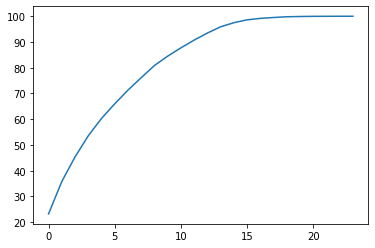

In [49]:
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

In [66]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [64]:
for n in range(1,24):
    pca=PCA(n_components=n)
    X1 = pca.fit_transform(X)
    # colnames = ["PC"+ str(i+1) for i in range(24)]
    # X1 = pd.DataFrame(X1,columns = colnames)
    Y = cec_2018_ml['tool_time_pct']*100
    model = LinearRegression(fit_intercept=True)
    predictions = cross_val_predict(model,X1,Y)
    model.fit(X1,Y)
    a = model.predict(X1)
#     print(pd.DataFrame(zip(a,Y)))
    print("Number of Principal Components", n)
    print("Test Error", cross_val_score(model,X1,Y,scoring='neg_mean_squared_error').mean()*-1)
    print("Training Error", sklearn.metrics.mean_squared_error(Y,a))

Number of Principal Components 1
Test Error 302.0016323111449
Training Error 221.47472272583823
Number of Principal Components 2
Test Error 428.8903979591576
Training Error 201.6176206082803
Number of Principal Components 3
Test Error 232.93865650945673
Training Error 166.7687279634216
Number of Principal Components 4
Test Error 285.44064106439134
Training Error 163.55344046682768
Number of Principal Components 5
Test Error 287.8030062153909
Training Error 160.45891493748226
Number of Principal Components 6
Test Error 1052.30158865873
Training Error 143.73939100979635
Number of Principal Components 7
Test Error 1770.7950309079029
Training Error 136.48781346195653
Number of Principal Components 8
Test Error 2992.6607150314812
Training Error 135.41634613398222
Number of Principal Components 9
Test Error 2701.6778127277353
Training Error 115.44956363796781
Number of Principal Components 10
Test Error 2910.9357572858944
Training Error 106.33191221012203
Number of Principal Components 11
Te

In [67]:
pca=PCA(n_components=3)
X1 = pca.fit_transform(X)
model = LinearRegression(fit_intercept=True)
predictions = cross_val_predict(model,X1,Y)
print(cross_val_score(model,X1,Y,scoring='neg_mean_squared_error'))
model.fit(X1,Y)
a = model.predict(X1)
print(pd.DataFrame(zip(a,Y)))
print(sklearn.metrics.mean_squared_error(Y,a))

[-305.7959126  -247.53068478 -135.17702735 -240.96297818 -235.22667963]
            0          1
0   56.075897  50.612245
1   55.448097  51.879699
2   54.059627  24.118738
3   53.763594  48.664688
4   55.968324  60.420650
5   55.451766  84.084881
6   67.561156  57.538929
7   48.079805  46.864349
8   56.925293  52.185609
9   59.458736  72.138554
10  59.688002  62.434260
11  49.717029  49.985070
12  56.473888  76.099707
13  59.567788  69.513485
14  59.227280  59.121756
15  51.823162  47.550586
16  51.858784  46.541353
17  60.380415  51.195029
18  68.945358  67.720418
19  54.469451  29.520295
20  54.631469  78.564103
21  85.838575  84.600197
22  56.987367  65.476190
23  56.444583  52.014652
166.7687279634216


            0          1
0   50.612245  61.626614
1   51.879699  61.018903
2   24.118738  59.335579
3   48.664688  57.817653
4   60.420650  60.052471
5   84.084881  53.603412
6   57.538929  67.996613
7   46.864349  46.461188
8   52.185609  55.466148
9   72.138554  58.418284
10  62.434260  57.129350
11  49.985070  46.655714
12  76.099707  55.331358
13  69.513485  55.317469
14  59.121756  57.170528
15  47.550586  54.349743
16  46.541353  51.407115
17  51.195029  65.390515
18  67.720418  81.668492
19  29.520295  56.702092
20  78.564103  50.527295
21  84.600197  87.900162
22  65.476190  53.494154
23  52.014652  52.635264


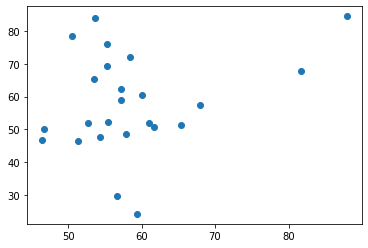

In [70]:
print(pd.DataFrame(zip(Y,predictions)))
plt.scatter(predictions,Y)

In [71]:
loadings = pd.DataFrame(pca.components_.T, columns=colnames, index=X_df.columns)
loadings

ValueError: Shape of passed values is (42, 3), indices imply (42, 24)

In [72]:
wo_df

,duration,clean_date,crew_size,labels,tool_time_pct
work_order,,,,,
21091147,5.916667,1,6.000000,2,0.698592
21097627,43.283333,7,2.866667,0,0.654987
21098008,8.833333,1,6.000000,2,0.320755
21098206,38.716667,4,3.750000,0,0.834266
21098749,14.066667,3,4.000000,0,0.496445
21106118,8.750000,1,2.000000,3,0.971429
21118243,34.850000,5,2.416667,0,0.653276
21118244,9.750000,1,1.000000,3,0.423932
21118249,23.866667,4,2.500000,0,0.458799


In [73]:
vessel_tooltime = (cec_2018[pd.notnull(cec_2018['code_phase'])].
                          pivot_table(values='duration',index=['vessel_clean'],columns='code_phase',
                                      aggfunc='sum'))
vessel_tooltime['tool_time_pct'] = (vessel_tooltime['tool_time']/
                                  vessel_tooltime.iloc[:,0:5].sum(axis=1))
vessel_tooltime

code_phase,down_time,idle_time,nonwork_time,tool_time,wait_time,tool_time_pct
vessel_clean,,,,,,
Blow Down Tank,6.950000,0.666667,NaN,6.900000,0.250000,0.467269
CT Exhaust Duct,11.716667,26.800000,0.233333,37.516667,3.883333,0.468081
CT Generator,20.066667,40.383333,0.066667,57.200000,4.116667,0.469494
CT Generator Vault,7.033333,16.466667,4.150000,16.766667,1.166667,0.367824
CT Inlet Scroll,5.000000,3.683333,2.633333,19.616667,1.100000,0.612383
Combustion Turbine Generator Vault,0.833333,2.100000,NaN,3.983333,0.333333,0.549425
Combustor Shell,0.833333,5.250000,NaN,2.666667,0.283333,0.295203
Condenser Hot Well Upper,NaN,0.016667,NaN,0.133333,0.100000,0.533333
Condenser Waterbox,3.666667,0.533333,4.800000,20.516667,0.333333,0.687326
